# Assignment 4 - Classification

## Prompt

Create classification model, predicting the outcome of food safety inspection based on the inspectors’ comments

- Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors
- Discard the text from “Health Code” – only keep inspectors’ comments
- Build classification model, predicting the outcome of inspection – your target variable is “Results”
- Explain why you selected a particular text pre-processing technique
- Visualize results of at least two text classifiers and select the most robust one
- You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

# Setup & Data

In [1]:
import sys
print(sys.version)

3.7.2 (default, Feb 12 2019, 08:15:36) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [2]:
import pandas as pd

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import regex

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import matplotlib.pyplot as plt

import sys
import time

In [3]:
data_path = "~/Datasets/31006/"
file_path = data_path + "Food_Inspections.csv"

insp = pd.read_csv(file_path)

print(insp.shape)

(186132, 22)


In [4]:
insp = insp[['Inspection ID','Violations', 'Results']]
insp['Violations'] = insp.Violations.fillna('')

Extract just the comments

In [5]:
def extract_comments(violation_text):
    return regex.findall('(?<=Comments: )[^|]*(?=\||$)', violation_text)

def group_result(result):
    if result == 'Pass':
        return 1
    elif result == 'Pass w/ Conditions':
        return 1
    else:
        return 0

In [6]:
insp.Results.value_counts()

Pass                    103450
Fail                     35914
Pass w/ Conditions       23106
Out of Business          16199
No Entry                  5771
Not Ready                 1626
Business Not Located        66
Name: Results, dtype: int64

In [7]:
extract_comments(insp.Violations[0])

['FOUND NO VOMIT AND DIARRHEA CLEAN UP POLICY.  PRIORITY FOUNDATION. NO CITATION ISSUED.7-38-005. MUST PROVIDE. ',
 'BACKFLOW PREVENTION DEVICES NOT FOUND FOR MOP SINK FAUCET. MUST PROVIDE. ',
 'FOUND LIGHT FIXTURES INSIDE COOLERS NOT SHIELDED. MUST PROVIDE.']

In [8]:
start_time = time.time()

ids = []
results = []
results_gpd = []
comments = []
for i, row in insp.iterrows():
    ids.append(row['Inspection ID'])
    result = row['Results']
    violation_comments = extract_comments(row['Violations'])
    for vc in violation_comments:
        
        comments.append(vc)
        results.append(result)
        results_gpd.append(group_result(result))

print("--- %s seconds ---" % (time.time() - start_time))

--- 32.274226903915405 seconds ---


In [9]:
df = pd.DataFrame({'comment': comments, 'result':results, 'result_gpd': results_gpd})

In [10]:
print(df.shape)
df.head()

(585633, 3)


,comment,result,result_gpd
0,FOUND NO VOMIT AND DIARRHEA CLEAN UP POLICY. ...,Pass w/ Conditions,1
1,BACKFLOW PREVENTION DEVICES NOT FOUND FOR MOP ...,Pass w/ Conditions,1
2,FOUND LIGHT FIXTURES INSIDE COOLERS NOT SHIELD...,Pass w/ Conditions,1
3,OBSERVED NO POLICY FOR EMPLOYEE HEALTH. INSTR...,Fail,0
4,NO EMPLOYEE PROCEDURE FOR VOMITING AND DIARRH...,Fail,0


# Text Processing

Test a few different methods of text processing

1. CountVectorizer with default params
2. CountVectorizer with adjusted params
3. TfidfVectorizer with default prams

In [11]:
X = df.comment
y = df.result_gpd

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20190502)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(439224,)
(146409,)
(439224,)
(146409,)


## CountVectorizer with Default Params

In [12]:
start_time = time.time()

cv_default = CountVectorizer()
cv_default.fit(X_train)
X_train_dtm_cv = cv_default.transform(X_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 25.053266048431396 seconds ---


In [13]:
X_train_dtm_cv

<439224x37833 sparse matrix of type '<class 'numpy.int64'>'
	with 10017278 stored elements in Compressed Sparse Row format>

In [14]:
X_test_dtm_cv = cv_default.transform(X_test)
X_test_dtm_cv

<146409x37833 sparse matrix of type '<class 'numpy.int64'>'
	with 3334468 stored elements in Compressed Sparse Row format>

## Count Vectorizer with Adjusted Params

In [15]:
start_time = time.time()

cv_adj = CountVectorizer(stop_words='english', ngram_range=(1,3))
cv_adj.fit(X_train)
X_train_dtm_cv_adj = cv_adj.transform(X_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 77.43006801605225 seconds ---


In [16]:
X_train_dtm_cv_adj

<439224x2126741 sparse matrix of type '<class 'numpy.int64'>'
	with 21565489 stored elements in Compressed Sparse Row format>

In [17]:
X_test_dtm_cv_adj = cv_adj.transform(X_test)
X_test_dtm_cv_adj

<146409x2126741 sparse matrix of type '<class 'numpy.int64'>'
	with 6741821 stored elements in Compressed Sparse Row format>

## TFIDF

In [18]:
tfidfvectorizer = TfidfVectorizer(stop_words='english')

In [19]:
start_time = time.time()

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train)
X_train_dtm_tfidf = tfidf.transform(X_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 25.654791116714478 seconds ---


In [20]:
X_train_dtm_tfidf.shape

(439224, 37558)

In [21]:
X_test_dtm_tfidf = tfidf.transform(X_test)
X_test_dtm_tfidf.shape

(146409, 37558)

# Modeling

## Logistic Regression

### CountVectorizer with Default Params

In [22]:
logreg_cv = LogisticRegression()
%time logreg_cv.fit(X_train_dtm_cv, y_train)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 2min 2s, sys: 450 ms, total: 2min 2s
Wall time: 2min 3s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
y_pred_class_cv = logreg_cv.predict(X_test_dtm_cv)
y_pred_proba_cv = logreg_cv.predict_proba(X_test_dtm_cv)

In [24]:
print(classification_report(y_test, y_pred_class_cv))

              precision    recall  f1-score   support

           0       0.73      0.33      0.45     51237
           1       0.72      0.93      0.81     95172

   micro avg       0.72      0.72      0.72    146409
   macro avg       0.72      0.63      0.63    146409
weighted avg       0.72      0.72      0.69    146409



In [25]:
roc_auc_score(y_test, y_pred_proba_cv[:,1])

0.7151263943421831

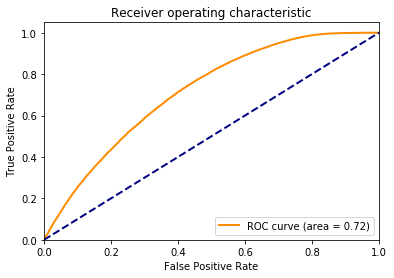

In [26]:
def roc_curve_plot(y_test_, y_pred_proba_):
    roc_score = roc_auc_score(y_test_, y_pred_proba_)
    fpr, tpr, thresholds = roc_curve(y_test_, y_pred_proba_)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
roc_curve_plot(y_test, y_pred_proba_cv[:,1])

### CountVectorizer with Adjusted Parameters

In [27]:
logreg_cv_adj = LogisticRegression()
%time logreg_cv_adj.fit(X_train_dtm_cv_adj, y_train)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 6min 28s, sys: 2.14 s, total: 6min 30s
Wall time: 6min 38s


/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
y_pred_class_cv_adj = logreg_cv_adj.predict(X_test_dtm_cv_adj)
y_pred_proba_cv_adj = logreg_cv_adj.predict_proba(X_test_dtm_cv_adj)

In [29]:
print(classification_report(y_test, y_pred_class_cv_adj))

              precision    recall  f1-score   support

           0       0.63      0.41      0.50     51237
           1       0.73      0.87      0.80     95172

   micro avg       0.71      0.71      0.71    146409
   macro avg       0.68      0.64      0.65    146409
weighted avg       0.70      0.71      0.69    146409



In [30]:
roc_auc_score(y_test, y_pred_proba_cv_adj[:,1])

0.7010258186984333

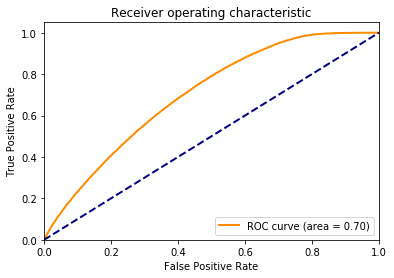

In [31]:
roc_curve_plot(y_test, y_pred_proba_cv_adj[:,1])

### TFIDF

In [32]:
logreg_tfidf = LogisticRegression()
%time logreg_tfidf.fit(X_train_dtm_tfidf, y_train)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 8.34 s, sys: 203 ms, total: 8.54 s
Wall time: 8.68 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
y_pred_class_tfidf = logreg_tfidf.predict(X_test_dtm_tfidf)
y_pred_proba_tfidf = logreg_tfidf.predict_proba(X_test_dtm_tfidf)

In [34]:
print(classification_report(y_test, y_pred_class_tfidf))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45     51237
           1       0.72      0.94      0.82     95172

   micro avg       0.72      0.72      0.72    146409
   macro avg       0.73      0.63      0.63    146409
weighted avg       0.73      0.72      0.69    146409



In [35]:
roc_auc_score(y_test, y_pred_proba_tfidf[:,1])

0.715761295675694

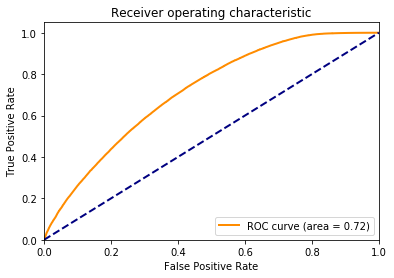

In [36]:
roc_curve_plot(y_test, y_pred_proba_tfidf[:,1])

## Support Vector Machines

### CountVectorizer with Default Params

In [37]:
start_time = time.time()

svc_cv = svm.LinearSVC()
svc_cv.fit(X_train_dtm_cv, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 168.58136796951294 seconds ---


/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [40]:
y_pred_class_cv_svm = svc_cv.predict(X_test_dtm_cv)

In [41]:
print(classification_report(y_test, y_pred_class_cv_svm))

              precision    recall  f1-score   support

           0       0.72      0.33      0.45     51237
           1       0.72      0.93      0.81     95172

   micro avg       0.72      0.72      0.72    146409
   macro avg       0.72      0.63      0.63    146409
weighted avg       0.72      0.72      0.68    146409



In [42]:
start_time = time.time()

svc_cv_adj = svm.LinearSVC()
svc_cv_adj.fit(X_train_dtm_cv_adj, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 274.7684452533722 seconds ---


/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [47]:
y_pred_class_cv_adj_svm = svc_cv_adj.predict(X_test_dtm_cv_adj)

In [48]:
print(classification_report(y_test, y_pred_class_cv_adj_svm))

              precision    recall  f1-score   support

           0       0.52      0.46      0.49     51237
           1       0.73      0.77      0.75     95172

   micro avg       0.66      0.66      0.66    146409
   macro avg       0.62      0.62      0.62    146409
weighted avg       0.65      0.66      0.66    146409



In [49]:
start_time = time.time()

svc_tfidf = svm.LinearSVC()
svc_tfidf.fit(X_train_dtm_tfidf, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.465412855148315 seconds ---


In [52]:
y_pred_class_tfidf_svm = svc_tfidf.predict(X_test_dtm_tfidf)

In [53]:
print(classification_report(y_test, y_pred_class_tfidf_svm))

              precision    recall  f1-score   support

           0       0.72      0.33      0.45     51237
           1       0.72      0.93      0.81     95172

   micro avg       0.72      0.72      0.72    146409
   macro avg       0.72      0.63      0.63    146409
weighted avg       0.72      0.72      0.69    146409



In [54]:
confusion_matrix(y_test, y_pred_class_tfidf_svm)

array([[16693, 34544],
       [ 6417, 88755]])

# Conclusions

Here I chose to compare CountVectorizer and TFIDF processing engines and Logistic Regression against SVM. What I found that was that LR and SVM both worked about the same with LR edging out SVM slighly in each case. This lines up with my prior experience. I have found that there are few cases where SVM outperforms LR on real-world data. 

With the classifying engines, I'm in love with TFIDF. While it didn't add a lot of accuracy after running it through the models, it's so fast! The processing time is an order of magnitude smaller than the default parameters on the CountVectorizer. I still don't fully understand how TFIDF works so I'm not sure why it's so much faster but I am much more willing to optimize and fiddle with reatures if it takes 10 seconds to run instead of 3 minutes.